# Notebook to train readout with pre-trained core on V1 data

In [1]:
%matplotlib inline
%load_ext autoreload
%load_ext memory_profiler
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import neuralpredictors as neur
from neuralpredictors.data.datasets import StaticImageSet, FileTreeDataset
import matplotlib as mpl
from datetime import date
from datetime import datetime
import os
from os import listdir
from os.path import join

In [4]:
#Helper fucntion to save text file with log information of the training stage
def save_training_log(info, model_name, path):
    with open(join(path,"Train_log_"+model_name+".txt"), "a") as log_file:
        log_file.write(info)

# Build the dataloaders

The dataloaders object is a dictionary of 3 dictionaries: train, validation and test. 

In [2]:
#Dataset directory
path_dataset = [r'C:\Users\inoca\Desktop\Intership EMBL\Python docs\Inception_loop\Ephy_data_Cortex\static20210629_train']

In [7]:
#Pad images of the dataset and save on dataset directory
n_images = len([img for img in listdir(join(path_dataset[0],'data','images_not_padded'))])
 
for n in range(n_images):
    x = np.load(join(path_dataset[0],'data','images_not_padded',str(n)+'.npy'))
    x_padded = np.pad(x[0], pad_width=20, mode='constant', 
              constant_values=0)
    np.save(join(path_dataset[0],'data','images',str(n)+'.npy'), [x_padded])

In [11]:
#Configure dataloader/s 
from lurz2020.datasets.mouse_loaders import static_loaders

dataset_config = {'paths': path_dataset, 
                  'batch_size': 64, 
                  'seed': 1,
                  'cuda': True,
                  'normalize': True, 
                  'include_eye_position': False,
                  'exclude': "images"}

dataloaders = static_loaders(**dataset_config)
dat = FileTreeDataset(path_dataset[0], "images", "responses")

### Look at the data

In [9]:
tier = 'train'
dataset_name = path_dataset[0].split("\\")[-1].replace('static','')

images, responses = [], []
for data in dataloaders[tier][dataset_name]:
    images.append(data[0].squeeze().cpu().data.numpy())
    responses.extend(data[1].squeeze().cpu().data.numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)

print('The \"{}\" set of dataset \"{}\" contains the responses of {} RGC neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

The "train" set of dataset "20210629_train" contains the responses of 3 RGC neurons to 1490 images


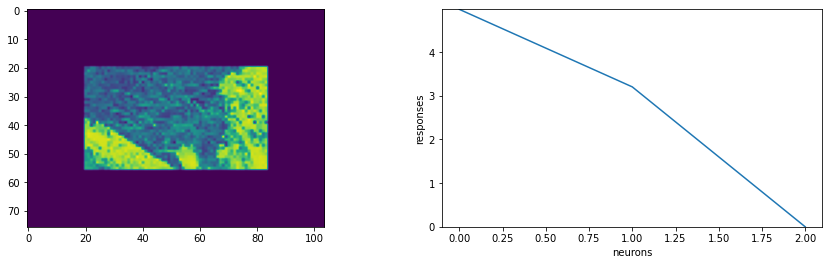

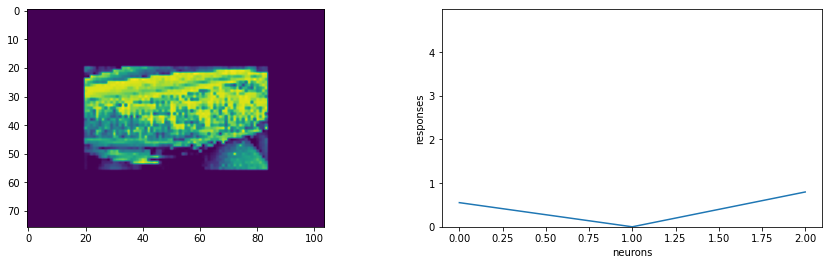

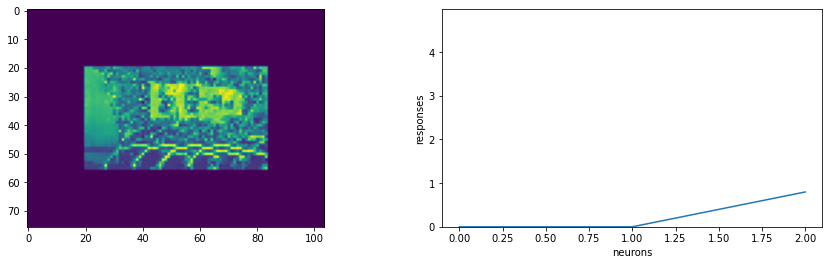

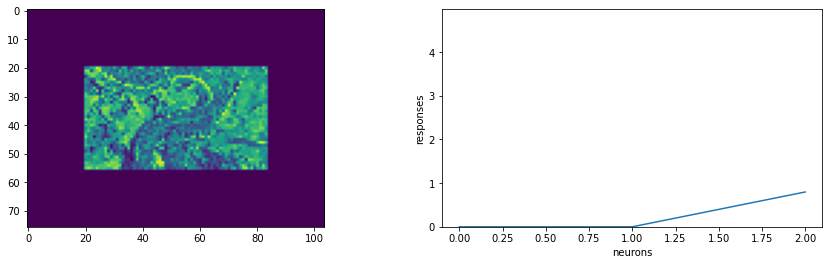

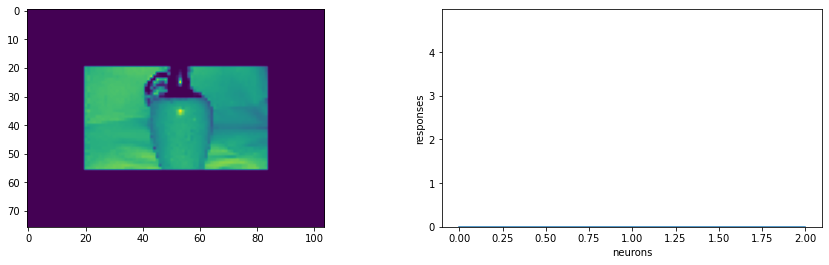

In [10]:
#Show some example images and the neural responses
n_images = 5
max_response = responses[:n_images].max()

for i in range(n_images):
    fig, axs = plt.subplots(1, 2, figsize=(15,4))
    axs[0].imshow(images[i])
    axs[1].plot(responses[i])
    axs[1].set_xlabel('neurons')
    axs[1].set_ylabel('responses')
    axs[1].set_ylim([0, max_response])
    plt.show()

# Build the model, transfer core, train and evaluate performance - 4 instances

Get 4 instances of the model for MEI generation:

In [15]:
%%time 
%%memit
from lurz2020.models.models import se2d_fullgaussian2d
from lurz2020.training.trainers import standard_trainer as trainer
from lurz2020.utility.measures import get_correlations, get_fraction_oracles, get_FEV

#Directory of core transfer model
path_transfer_model = r"C:\Users\inoca\Desktop\Intership EMBL\Python docs\Inception_loop\inception_loop_asari_lab\src\lurz2020\notebooks\models\transfer_model.pth.tar"
#Directory to sava models after training
path_models = join(path_dataset[0], 'models')
os.makedirs(path_models) 
#Models name 
models_name = 'tunned_model_ephy_data_cortex_'
#Generate 4 instances of the same model with different seeds, for MEI generation
n_seeds = 4
#Model config
model_config_tunned = {'init_mu_range': 0.1,
                'init_sigma': 0.64,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': None,
                'gamma_readout': 0.99}
#Change trainer config to not track and print the training progress
trainer_config = {'track_training': False,
                  'verbose': None,
                  'detach_core': True}
#Save information of the training stage
comment = "Comment: Results for tunned fullgaussian model with V1 core and readout trained with ephy data with only 3 neurons with possible spatial rf in the visual field, recorded in the cortex." 
date = "Date: " + datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
stim = "Stimuli dataset: " + dataset_name
model_config = "Model configuration: " + str(model_config_tunned)
log_info = comment+'\n\n'+date+'\n'+ stim+'\n'+model_config+'\n'

save_training_log(log_info, models_name, path_models)
    
#Initialize variables for loop
models = []
train_correlation_models = []
validation_correlation_models = []
test_correlation_models = []
fraction_oracle = []
exp_var_models = []
model_state_before = [] 
model_state_after = []
for i in range(n_seeds): 

    model = se2d_fullgaussian2d(**model_config_tunned, dataloaders=dataloaders, seed=i)
    
    #Load the weights of the transfer core 
    transfer_model = torch.load(path_transfer_model) 
    model.load_state_dict(transfer_model, strict=False)
    model_state_before.append(model.state_dict())
    
    #Run training
    score, output, model_state = trainer(model=model, dataloaders=dataloaders, seed=1, **trainer_config)
    model_state_after.append(model.state_dict())
    
    #Get performance of model
    train_correlation_models.append(get_correlations(model, dataloaders["train"], device='cuda', as_dict=False, per_neuron=False))
    validation_correlation_models.append(get_correlations(model, dataloaders["validation"], device='cuda', as_dict=False, per_neuron=False))
    test_correlation_models.append(get_correlations(model, dataloaders["test"], device='cuda', as_dict=False, per_neuron=False))
    
    oracle_dataloader = static_loaders(**dataset_config, return_test_sampler=True, tier='test')
    fraction_oracle.append(get_fraction_oracles(model=model, dataloaders=oracle_dataloader, device='cuda')[0])
    exp_var_models.append(get_FEV(model, oracle_dataloader, device='cuda', as_dict=False, per_neuron=False, threshold=None))

    instance_results = '\n ----------------------------------------- \n \
    Model instance #{0:1d} \n \
    Correlation (train set):      {1:.3f} \n \
    Correlation (validation set): {2:.3f} \n \
    Correlation (test set):       {3:.3f} \n \
    ----------------------------------------- \n \
    Fraction oracle (test set):   {4:.3f} \n \
    FEV (test set): {5:.3f}  \n'.format(i, train_correlation_models[i], validation_correlation_models[i],
                                        test_correlation_models[i], fraction_oracle[i], exp_var_models[i])
    
   #Print and save instance training data on train log file
    print(instance_results)
    log_info = "\n Model instances training results: \n"+ instance_results
    save_training_log(log_info, models_name, path_models)
        
    #Save model state for loading later
    models.append(model)
    torch.save(model_state, join(path_models,models_name+str(i)+'.pth'))

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:10<00:00,  2.38it/s]


[001|00/05] ---> 0.05537644028663635


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.08it/s]


[002|01/05] -/-> 0.03918788582086563


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.11it/s]


[003|02/05] -/-> 0.033401038497686386


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.50it/s]


[004|03/05] -/-> 0.0457245372235775


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.43it/s]


[005|04/05] -/-> 0.037673357874155045


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.51it/s]


[006|05/05] -/-> 0.03342219442129135


Epoch 7:   0%|                                                                                  | 0/24 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.033422 ---> 0.055376


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:05<00:00,  4.10it/s]


[007|01/05] -/-> 0.03907391056418419


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.41it/s]


[008|02/05] -/-> 0.03870963305234909


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.89it/s]


[009|03/05] -/-> 0.04799159988760948


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.13it/s]


[010|04/05] -/-> 0.045370977371931076


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.06it/s]


[011|04/05] ---> 0.05600227788090706


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.63it/s]


[012|01/05] -/-> 0.05185423418879509


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.66it/s]


[013|02/05] -/-> 0.045549292117357254


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.60it/s]


[014|03/05] -/-> 0.03035111166536808


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.62it/s]


[015|04/05] -/-> 0.047115933150053024


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.62it/s]


[016|04/05] ---> 0.06076034903526306


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.36it/s]


[017|01/05] -/-> 0.059051841497421265


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.63it/s]


[018|02/05] -/-> 0.058915410190820694


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.69it/s]


[019|03/05] -/-> 0.05148361623287201


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:07<00:00,  3.16it/s]


[020|04/05] -/-> 0.05676383897662163


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  7.33it/s]


[021|05/05] -/-> 0.05338924005627632


Epoch 22:  12%|█████████▏                                                               | 3/24 [00:00<00:01, 16.85it/s]

Restoring best model after lr decay! 0.053389 ---> 0.060760


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.08it/s]


[022|00/05] ---> 0.06256631761789322


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.85it/s]


[023|01/05] -/-> 0.051174093037843704


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.03it/s]


[024|02/05] -/-> 0.049647342413663864


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.15it/s]


[025|03/05] -/-> 0.034245189279317856


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.18it/s]


[026|04/05] -/-> 0.02744126133620739


Epoch 27: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.23it/s]


[027|05/05] -/-> 0.04210348799824715
Restoring best model after lr decay! 0.042103 ---> 0.062566
Restoring best model! 0.062566 ---> 0.062566
Returning only test sampler with repeats...


c:\users\inoca\desktop\intership embl\python docs\inception_loop\inception_loop_asari_lab\src\lurz2020\lurz2020\utility\measures.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(repeated_inputs), np.array(repeated_outputs)
c:\users\inoca\desktop\intership embl\python docs\inception_loop\inception_loop_asari_lab\src\lurz2020\lurz2020\utility\measures.py:259: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  oracle_performance, _, _, _ = np.linalg.lstsq(np.hstack(oracles)[:, np.newaxis], np.hstack(test_correlation))
c:\u


 ----------------------------------------- 
     Model instance #0 
     Correlation (train set):      0.099 
     Correlation (validation set): 0.063 
     Correlation (test set):       0.064 
     ----------------------------------------- 
     Fraction oracle (test set):   0.069 
     FEV (test set): nan  



Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.16it/s]


[001|00/05] ---> 0.03303343802690506


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.15it/s]


[002|00/05] ---> 0.04132925346493721


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.14it/s]


[003|00/05] ---> 0.07335304468870163


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.99it/s]


[004|01/05] -/-> 0.05691777169704437


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.21it/s]


[005|02/05] -/-> 0.045912619680166245


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.08it/s]


[006|03/05] -/-> 0.05775342509150505


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.20it/s]


[007|04/05] -/-> 0.060313548892736435


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.23it/s]


[008|05/05] -/-> 0.0668991282582283


Epoch 9:   0%|                                                                                  | 0/24 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.066899 ---> 0.073353


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.08it/s]


[009|01/05] -/-> 0.06276705116033554


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.05it/s]


[010|02/05] -/-> 0.05671464279294014


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.17it/s]


[011|03/05] -/-> 0.06675123423337936


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.22it/s]


[012|04/05] -/-> 0.07324901968240738


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.22it/s]


[013|05/05] -/-> 0.06830840557813644


Epoch 14:  12%|█████████▏                                                               | 3/24 [00:00<00:01, 17.38it/s]

Restoring best model after lr decay! 0.068308 ---> 0.073353


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.23it/s]


[014|01/05] -/-> 0.07212533801794052


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 10.62it/s]


[015|02/05] -/-> 0.07201969623565674


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 10.42it/s]


[016|03/05] -/-> 0.07171935588121414


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.08it/s]


[017|03/05] ---> 0.07422144711017609


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.55it/s]


[018|01/05] -/-> 0.07336732000112534


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.52it/s]


[019|01/05] ---> 0.07548287510871887


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.43it/s]


[020|00/05] ---> 0.07761812955141068


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.80it/s]


[021|00/05] ---> 0.07823687046766281


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.76it/s]


[022|01/05] -/-> 0.07688060402870178


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.74it/s]


[023|02/05] -/-> 0.07215085625648499


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.38it/s]


[024|03/05] -/-> 0.07652983069419861


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.22it/s]


[025|04/05] -/-> 0.0738995149731636


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.15it/s]


[026|05/05] -/-> 0.07792171090841293
Restoring best model after lr decay! 0.077922 ---> 0.078237
Restoring best model! 0.078237 ---> 0.078237
Returning only test sampler with repeats...

 ----------------------------------------- 
     Model instance #1 
     Correlation (train set):      0.090 
     Correlation (validation set): 0.078 
     Correlation (test set):       0.077 
     ----------------------------------------- 
     Fraction oracle (test set):   0.190 
     FEV (test set): nan  



Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.50it/s]


[001|00/05] ---> 0.029158374294638634


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.37it/s]


[002|01/05] -/-> 0.02371419407427311


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.02it/s]


[003|02/05] -/-> 0.023076027631759644


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.98it/s]


[004|02/05] ---> 0.0817258358001709


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.93it/s]


[005|00/05] ---> 0.08850838989019394


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.34it/s]


[006|01/05] -/-> 0.07953941076993942


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.76it/s]


[007|02/05] -/-> 0.08171902596950531


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.18it/s]


[008|03/05] -/-> 0.0683002844452858


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.30it/s]


[009|04/05] -/-> 0.060140833258628845


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.35it/s]


[010|05/05] -/-> 0.05499790981411934


Epoch 11:   8%|██████                                                                   | 2/24 [00:00<00:01, 19.58it/s]

Restoring best model after lr decay! 0.054998 ---> 0.088508


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.18it/s]


[011|01/05] -/-> 0.06321422755718231


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.65it/s]


[012|02/05] -/-> 0.0657932236790657


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.50it/s]


[013|03/05] -/-> 0.07286273688077927


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.52it/s]


[014|04/05] -/-> 0.0684252381324768


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.44it/s]


[015|05/05] -/-> 0.07146280258893967


Epoch 16:   8%|██████                                                                   | 2/24 [00:00<00:01, 19.20it/s]

Restoring best model after lr decay! 0.071463 ---> 0.088508


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.52it/s]


[016|01/05] -/-> 0.07309147715568542


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.21it/s]


[017|02/05] -/-> 0.07292427867650986


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.17it/s]


[018|03/05] -/-> 0.06928900629281998


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.23it/s]


[019|04/05] -/-> 0.07602393627166748


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.53it/s]


[020|05/05] -/-> 0.07682859152555466
Restoring best model after lr decay! 0.076829 ---> 0.088508
Restoring best model! 0.088508 ---> 0.088508
Returning only test sampler with repeats...

 ----------------------------------------- 
     Model instance #2 
     Correlation (train set):      0.084 
     Correlation (validation set): 0.089 
     Correlation (test set):       0.124 
     ----------------------------------------- 
     Fraction oracle (test set):   0.445 
     FEV (test set): nan  



Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.25it/s]


[001|00/05] ---> 0.06261248141527176


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.93it/s]


[002|00/05] ---> 0.0633377805352211


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.86it/s]


[003|00/05] ---> 0.07498788088560104


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.71it/s]


[004|01/05] -/-> 0.0626956894993782


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.09it/s]


[005|02/05] -/-> 0.061562564224004745


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.00it/s]


[006|02/05] ---> 0.07814548164606094


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.05it/s]


[007|01/05] -/-> 0.06650561839342117


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 13.12it/s]


[008|02/05] -/-> 0.04741399362683296


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.90it/s]


[009|03/05] -/-> 0.06579843908548355


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 11.97it/s]


[010|03/05] ---> 0.10695400089025497


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.70it/s]


[011|01/05] -/-> 0.0927499309182167


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.70it/s]


[012|02/05] -/-> 0.0831691101193428


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.49it/s]


[013|03/05] -/-> 0.08413609117269516


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.50it/s]


[014|04/05] -/-> 0.06893214583396912


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.50it/s]


[015|05/05] -/-> 0.0644383653998375


Epoch 16:   8%|██████                                                                   | 2/24 [00:00<00:01, 17.83it/s]

Restoring best model after lr decay! 0.064438 ---> 0.106954


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.44it/s]


[016|01/05] -/-> 0.08489763736724854


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.27it/s]


[017|02/05] -/-> 0.08507845550775528


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.41it/s]


[018|03/05] -/-> 0.09177208691835403


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.58it/s]


[019|04/05] -/-> 0.1011994257569313


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.57it/s]


[020|05/05] -/-> 0.10341280698776245


Epoch 21:   8%|██████                                                                   | 2/24 [00:00<00:01, 18.16it/s]

Restoring best model after lr decay! 0.103413 ---> 0.106954


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.04it/s]


[021|01/05] -/-> 0.10294413566589355


Epoch 22: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.75it/s]


[022|02/05] -/-> 0.10211501270532608


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.47it/s]


[023|03/05] -/-> 0.10247727483510971


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.29it/s]


[024|04/05] -/-> 0.10325318574905396


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 12.32it/s]


[025|05/05] -/-> 0.10426479578018188
Restoring best model after lr decay! 0.104265 ---> 0.106954
Restoring best model! 0.106954 ---> 0.106954
Returning only test sampler with repeats...

 ----------------------------------------- 
     Model instance #3 
     Correlation (train set):      0.121 
     Correlation (validation set): 0.107 
     Correlation (test set):       0.111 
     ----------------------------------------- 
     Fraction oracle (test set):   0.577 
     FEV (test set): nan  

peak memory: 3568.77 MiB, increment: 1842.91 MiB
Wall time: 8min 12s


In [16]:
#Print results of after training step
results = "\n Results for " + models_name + " model: \n \
    ----------------------------------------- \n \
    {0:1d} instances of the model trained \n \
    Mean correlation (train set):      {1:.3f} \n \
    Mean correlation (validation set): {2:.3f} \n \
    Mean correlation (test set):       {3:.3f} \n \
    ----------------------------------------- \n \
    Mean fraction oracle (test set):   {4:.3f} \n \
    Mean FEV (test set): {5:.3f} \n ".format(
    len(train_correlation_models), np.mean(train_correlation_models), np.mean(validation_correlation_models), 
    np.mean(test_correlation_models), np.mean(fraction_oracle), np.mean(exp_var_models))
    
#Print and save average performance results on train log file
print(results)
log_info = results
save_training_log(log_info, models_name, path_models)


 Results for tunned_model_ephy_data_cortex_ model: 
     ----------------------------------------- 
     4 instances of the model trained 
     Mean correlation (train set):      0.098 
     Mean correlation (validation set): 0.084 
     Mean correlation (test set):       0.094 
     ----------------------------------------- 
     Mean fraction oracle (test set):   0.320 
     Mean FEV (test set): nan 
 


### Predict neural responses to an image (here from the train set)

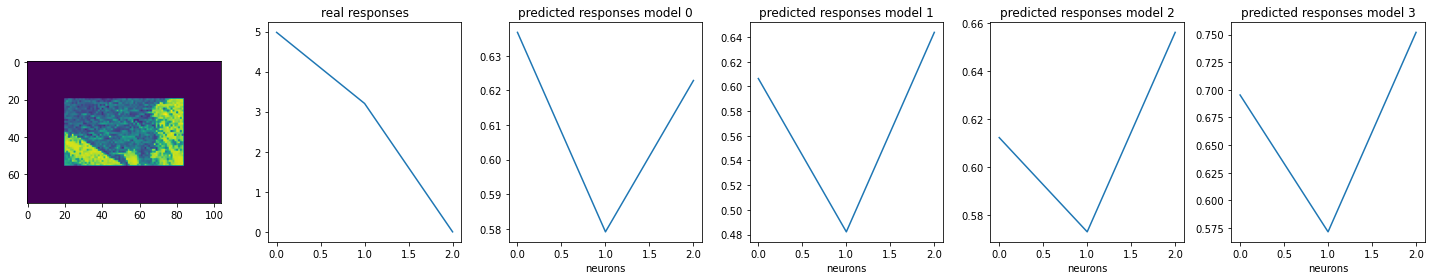

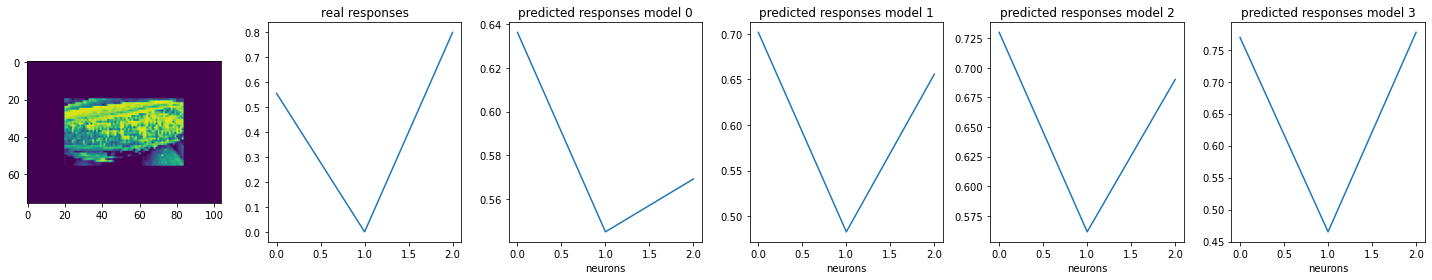

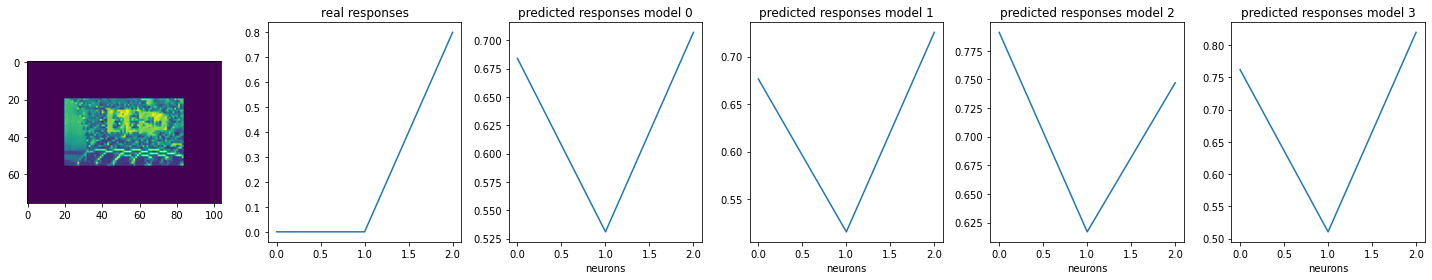

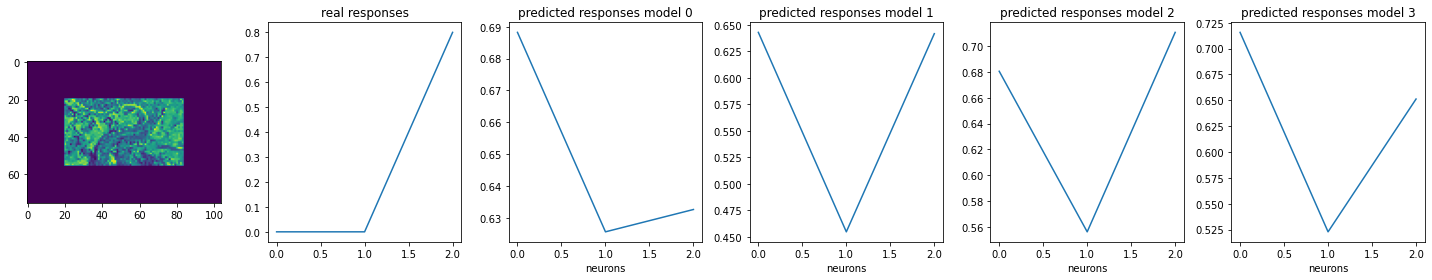

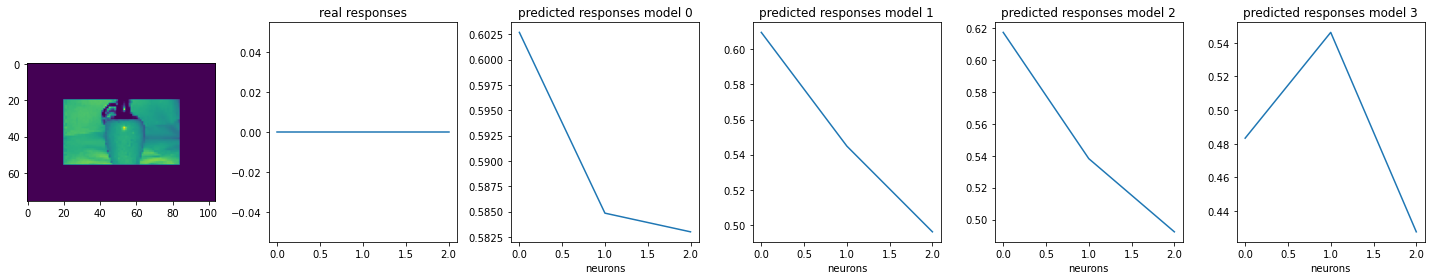

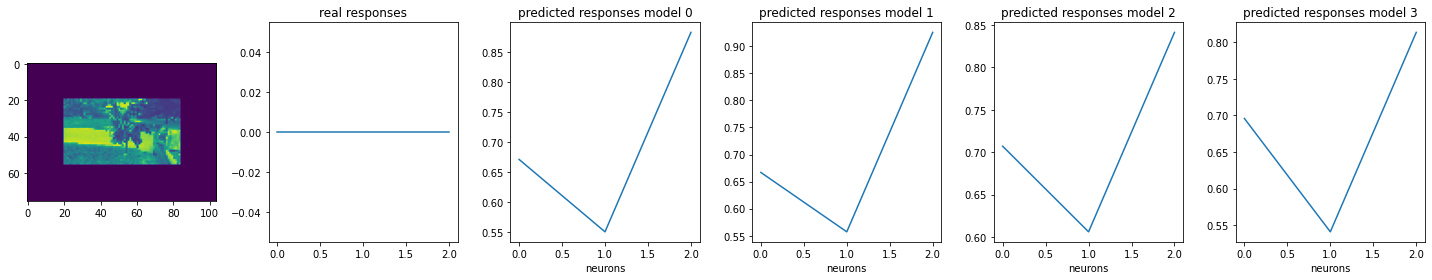

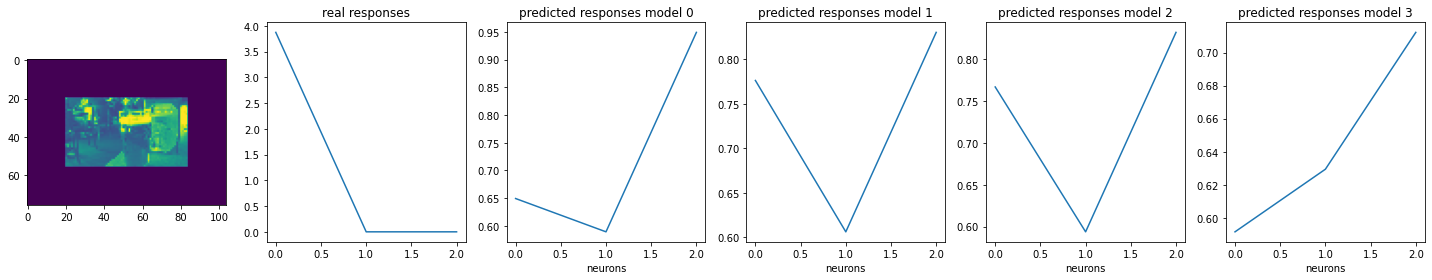

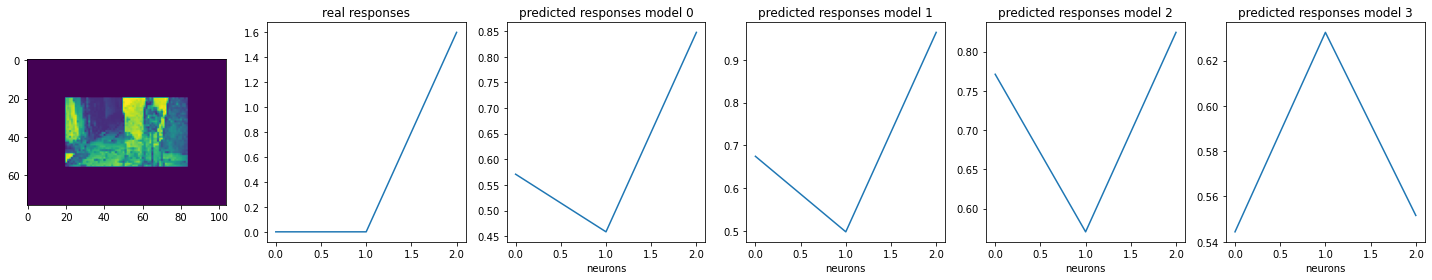

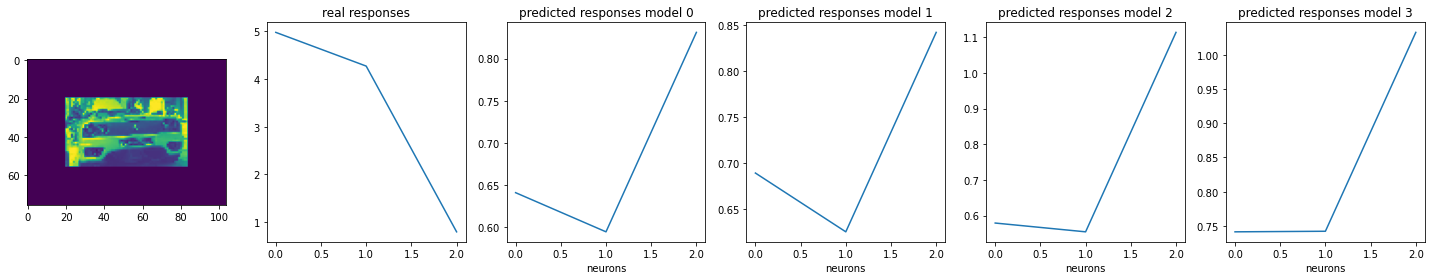

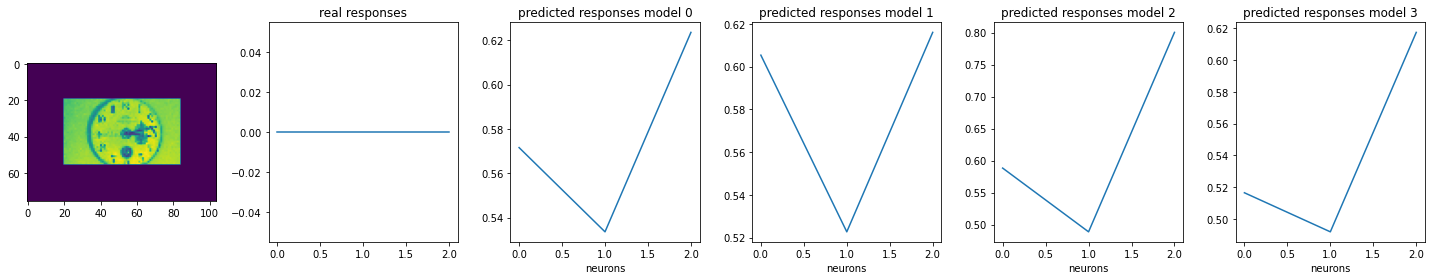

In [17]:
# show some example images and the neural responses
n_images = 10
max_response = responses[:n_images].max()

for i in range(n_images):
    input_image = images[i]
    fig, axs = plt.subplots(1, 6, figsize=(20,4))
    axs[0].imshow(input_image)
    axs[1].plot(responses[i])
    axs[1].set_title('real responses')
    
    for n in range(len(models)):

        predicted_response = models[n](torch.from_numpy(input_image).view(1,1,input_image.shape[0],input_image.shape[1]).cuda())
        predicted_response = predicted_response.squeeze().cpu().data.numpy()
        axs[n+2].plot(predicted_response)
        axs[n+2].set_xlabel('neurons')
        axs[n+2].set_title('predicted responses model '+str(n))
  

    plt.tight_layout()
    plt.show()

-------------------

In [18]:
torch.cuda.empty_cache()

-----------------------------